In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

np.random.seed(42)

In [11]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500

X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T


In [12]:
def kmeans_display(X, label, ax, title):
    K = np.amax(label) + 1
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
    ax.plot(X0[:, 0], X0[:, 1], 'b^', markersize = 4, alpha = .8)
    ax.plot(X1[:, 0], X1[:, 1], 'go', markersize = 4, alpha = .8)
    ax.plot(X2[:, 0], X2[:, 1], 'rs', markersize = 4, alpha = .8)
    ax.set_title(title)
    ax.axis('equal') # scale các trục để tỷ lệ giống nhau


In [13]:
model = KMeans(n_clusters=3, random_state=42).fit(X)
print('Centers found by scikit-learn:')
print(model.cluster_centers_)
pred_label = model.predict(X)

Centers found by scikit-learn:
[[8.06633167 3.06841999]
 [3.00344394 6.01652738]
 [1.9863215  2.00490262]]


In [14]:
def drawClusters(X, labels_arr, title_arr = ["Clusters"], markers=[]):
    arr_len = len(labels_arr)
    isMultiCols = arr_len > 1

    _ , axes = plt.subplots(1, len(labels_arr), figsize=(9*arr_len,5))
    if (isMultiCols):
        axes = axes.flatten()

    for i, label in enumerate(labels_arr):
        ax =  axes[i] if isMultiCols else axes
        sns.scatterplot(
            x=X[:, 0], 
            y=X[:, 1],
            hue = label,
            palette="Set2",
            s=60,
            ax = ax
        )
        ax.set_title(title_arr[i])
        ax.axis('equal') # scale các trục để tỷ lệ giống nhau

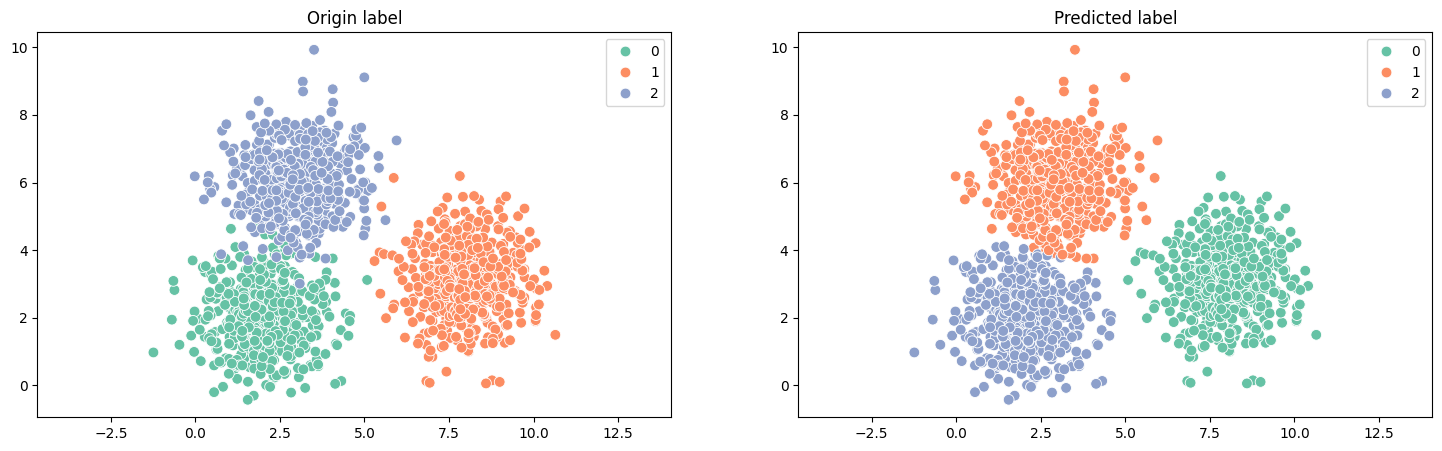

In [15]:
#_, ax = plt.subplots(1, 2,figsize = (12,6))
    
# kmeans_display(X, original_label, ax[0], "Origin label")
# kmeans_display(X, pred_label, ax[1], "Predicted label")

drawClusters(X, [original_label, pred_label], ["Origin label","Predicted label"])

TSNE to reduce number of dimensions of data to visualize 

In [16]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

print(X_tsne.shape)



(1500, 2)


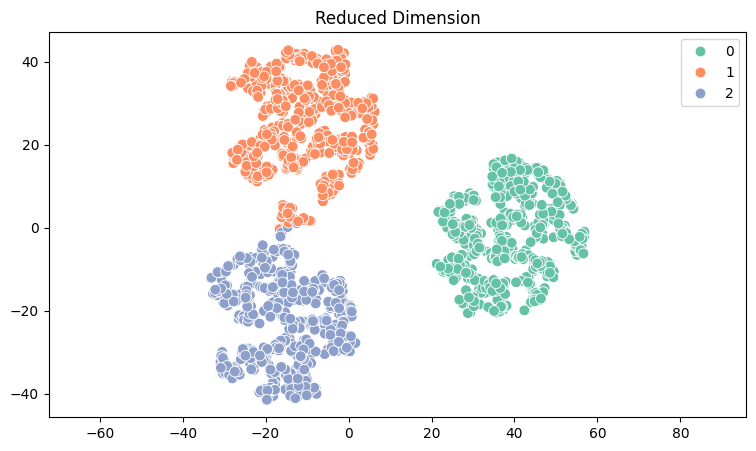

In [22]:
drawClusters(X_tsne, [pred_label], ["Reduced Dimension"])

### Model Evaluation 
- Internal evaluation: if do not have ground truth
    - Silhouette Score:  [0.5, 1.0]
        $$Silhouette_i = \frac{b_i-a_i}{max(a_i,b_i)} $$
        - a: The average distance from point 𝑖 between points in the same cluster.
        - b: The smallest average distance from point 𝑖 to points in any other cluster.
        - $$S= \frac{1}{N} \sum_{i=1}^{N} s_i$$


        - good when between [0.5, 1.0]
        - close to 0: overlap cluster
        - < 0: bad 
    - Davies–Bouldin Index (DBI): the lower, the better (độ tách rời cụm)
    - Calinski–Harabasz Index: the higher, the better (scatter ratio)
- External evaluation: if have ground truth
    - Adjusted Rand Index (ARI): [-1, 1], the higher the better 
    - Normalized Mutual Information (NMI): [0, 1], the higher the better 
    - Homogeneity: each cluster contains one class
    - Completeness: each class end up in one cluster
    - V-Measure: harmonic mean of Homogeneity and Completeness

In [18]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score


silhouette = silhouette_score(X, pred_label)
davis = davies_bouldin_score(X, pred_label)
calinski = calinski_harabasz_score(X, pred_label)

ari_score = adjusted_rand_score(original_label, pred_label)
nmi_score = normalized_mutual_info_score(original_label, pred_label)

homo_score = homogeneity_score(original_label, pred_label)
compl_score = completeness_score(original_label, pred_label) 
v_measure = v_measure_score(original_label, pred_label)
#silhouette, davis, calinski, ari_score, nmi_score

print(f"Silhouette Score: {silhouette}")
print(f"Davies–Bouldin Index: {davis}")
print(f"Calinski–Harabasz Index: {calinski}")
print(10*'-')
print(f"Adjusted Rand Index (ARI): {ari_score}")
print(f"Normalized Mutual Information (NMI): {nmi_score}")
print(f"Homogeneity: {homo_score}")
print(f"Completeness: {compl_score}")
print(f"V-Measure: {v_measure}")


Silhouette Score: 0.6199581345296806
Davies–Bouldin Index: 0.5325796664351822
Calinski–Harabasz Index: 3915.5788433793723
----------
Adjusted Rand Index (ARI): 0.954771378214766
Normalized Mutual Information (NMI): 0.928762316916831
Homogeneity: 0.9287302222170736
Completeness: 0.9287944138348976
V-Measure: 0.928762316916831


### Choose the best K

### 1. Elbow Method:
- Inertia = sum of squared distances from each point to its assigned cluster centroid. 
$$Inertia=\sum_{}^{}distance to centroid$$
- Choose the value of K when inertia 
    - stops decreasing sharply
    - and starts decreasing slowly / linearly

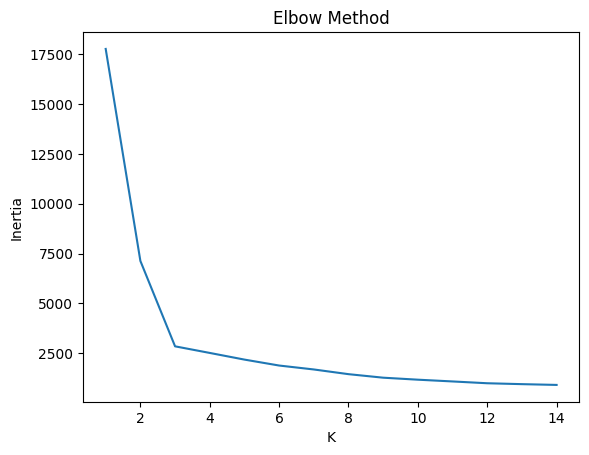

In [19]:
inertias = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

2. Silhouette
- Choose K with the highest Silhouette Score.

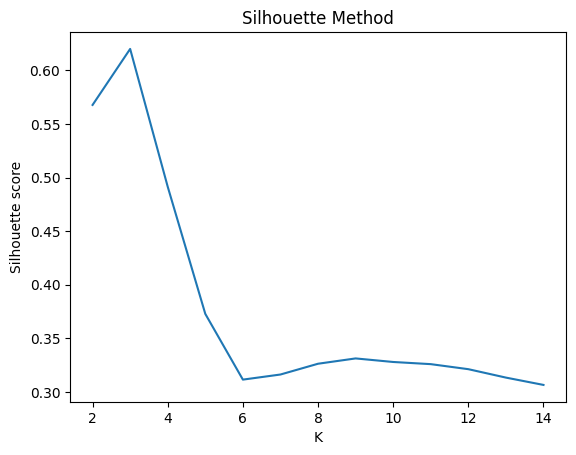

In [20]:
sil_scores = []
K_range = range(2, 15)

for k in K_range:
    predicts = KMeans(n_clusters=k, random_state=42).fit_predict(X)
    sil_scores.append(silhouette_score(X, predicts))

plt.plot(K_range, sil_scores)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.show()

3. Davies–Bouldin Index (DBI)
- Choose K with the lowest DBI

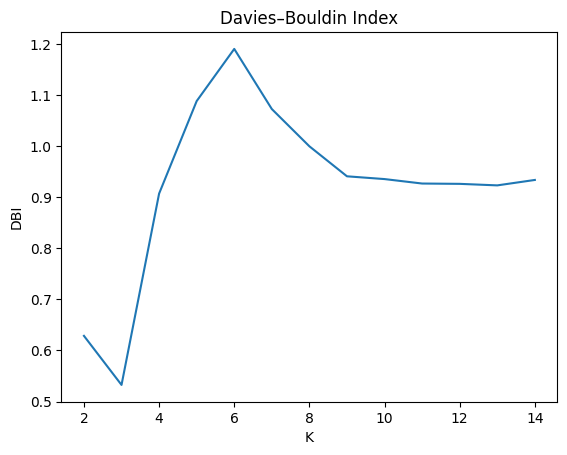

In [21]:
dbi_scores = []
for k in K_range: 
    predicts = KMeans(n_clusters=k, random_state=42).fit_predict(X)
    dbi_scores.append(davies_bouldin_score(X, predicts))

plt.plot(K_range, dbi_scores)
plt.xlabel('K')
plt.ylabel('DBI')
plt.title("Davies–Bouldin Index")
plt.show()